In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [ ]:
BASE_PATH = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/train_set'
unique_classes = []
for path in os.listdir(BASE_PATH):
    unique_classes.append(path)
print(unique_classes)

['Normal cases', 'Bengin cases', 'Malignant cases']


In [ ]:
class_index = [unique_classes[1], unique_classes[0], unique_classes[2]]
for c in class_index:
    print(c, "-", class_index.index(c))

Bengin cases - 0
Normal cases - 1
Malignant cases - 2


In [ ]:
images = []
masks = []
labels = []
for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [ ]:
print(len(images))

939


In [ ]:
images[0]

'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/train_set/Normal cases/Normal case (1).jpg'

In [ ]:
input_images_size = 256
channel = 1

In [ ]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
    """ Load single image as Grayscale
    """
    # load image as grayscale
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    """ Pad images to make them square
    """
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2

    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
    """Resize mask, its different because mask pixel value can change because of resize
    """
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
    """Resize image
    """
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img

def preprocess(img):
    """Image preprocessing
    Normalize image
    """
    img = img/255.0
    return img

def inverse_preprocess(img):
    """Inverse of preprocessing
    """
    img = img*255
    return img

def load_data(img_path, msk_path, label):
    """Load image, mask and repalce mask value with class index
    0 = normal
    1 = benign
    2 = malignant
    """
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    label_indx = class_index.index(label)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)
    new_mask = np.zeros((input_images_size, input_images_size, 2))
    if label_indx != 0:
        new_mask[:, :, label_indx-1] = msk
#     print(np.unique(msk), label, label_indx)
    return img, new_mask

def load_batch(images, masks, labels):
    """Load Batch of data
    """
    batch_x = []
    batch_y = []
    for i, m, l in zip(images, masks, labels):
        img, msk = load_data(i, m, l)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y)

<ipython-input-9-1e523946cf1c>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


37.5 255.0 (256, 256)


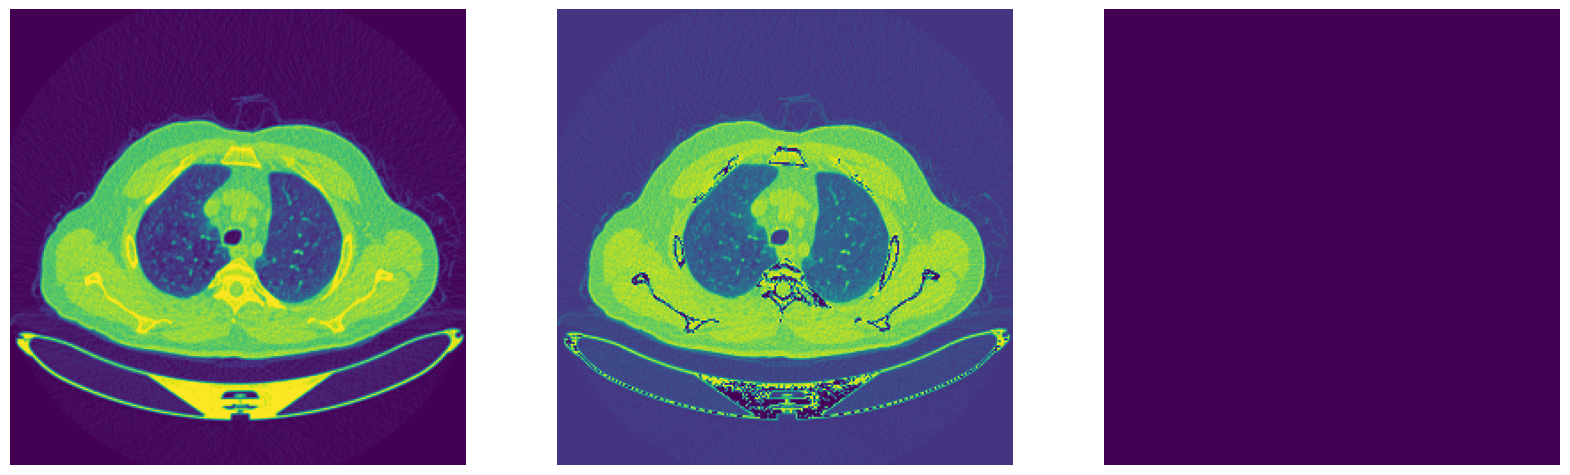

37.5 255.0 (256, 256)


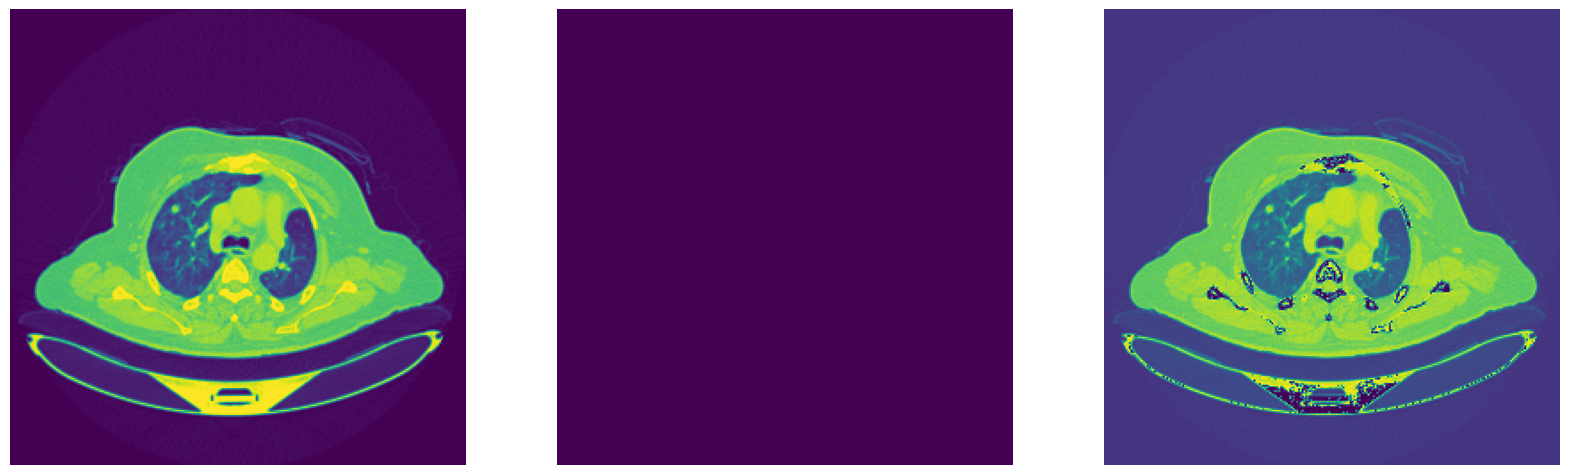

38.0 255.0 (256, 256)


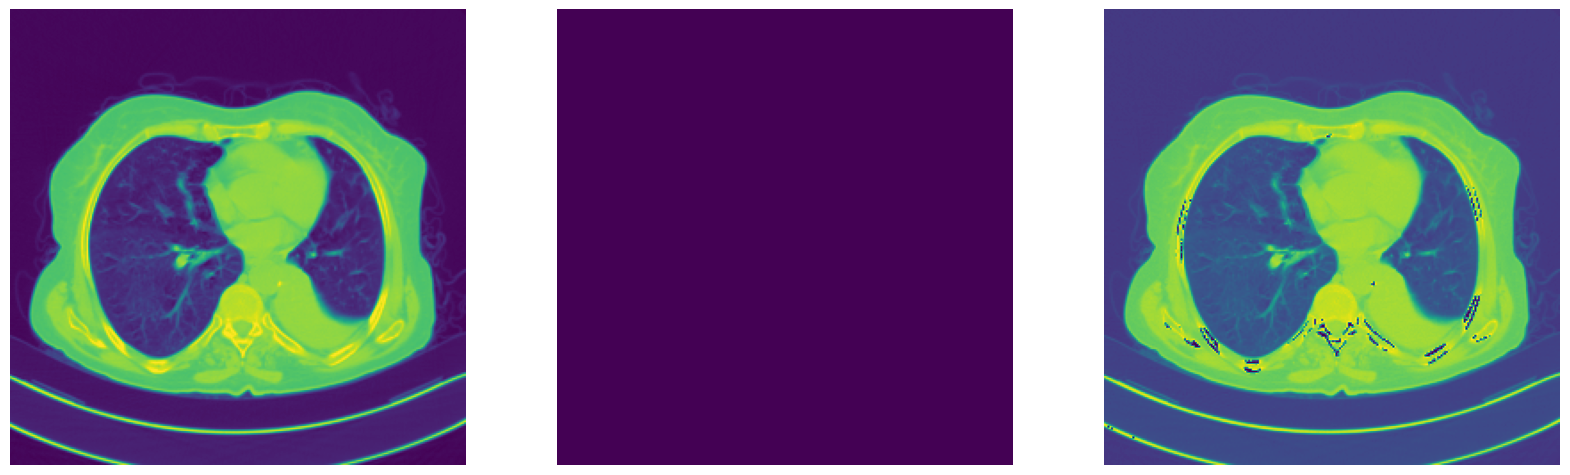

In [ ]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(msk[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(msk[:, :, 1])
    plt.show()

In [ ]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.


In [ ]:
!pip install -U keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import segmentation_models as sm
import tensorflow as tf
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
LR = 0.00001
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size,
                             input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


In [17]:
batch_size = 4
history = {"epoch": []}
for e in range(10):
    print("epoch:",e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [],
                   "IOU": [],
                   "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = bs+batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
         "IOU", np.round(np.mean(temp_history["IOU"]), 4),
         "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)

model.save_weights("lung_cancer_segmentation")

epoch: 0 > 

<ipython-input-9-1e523946cf1c>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


loss -16.5278 IOU 0.9901 F-Score 0.5866
epoch: 1 > loss -35.6066 IOU 0.9092 F-Score 0.5811
epoch: 2 > loss -47.8182 IOU 0.798 F-Score 0.5497
epoch: 3 > loss -51.8192 IOU 0.7996 F-Score 0.5631
epoch: 4 > loss -62.0418 IOU 0.8908 F-Score 0.5817
epoch: 5 > loss -68.2549 IOU 0.9393 F-Score 0.5886
epoch: 6 > loss -75.5569 IOU 0.9394 F-Score 0.5935
epoch: 7 > loss -81.7673 IOU 0.9925 F-Score 0.6036
epoch: 8 > loss -89.4566 IOU 0.9785 F-Score 0.6043
epoch: 9 > loss -99.0324 IOU 0.964 F-Score 0.5982


In [20]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)

    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(pred[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(pred[:, :, 1])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
import shutil
shutil.move('/content/lung_cancer_segmentation.data-00000-of-00001', '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/models')
shutil.move('/content/lung_cancer_segmentation.index', '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/models')

'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/models/lung_cancer_segmentation.index'